In [1]:
!pip install pandas presidio-analyzer presidio-anonymizer torch transformers


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.9/104.9 kB 6.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Load Reddit CSV
df = pd.read_csv("/kaggle/input/redditposts/cleaned_reddit_posts_final.csv")

# Initialize Presidio Analyzer and Anonymizer
analyzer = AnalyzerEngine()
anonymizer = AnonymizerEngine()

# For tracking Presidio actions
def anonymize_text_with_tracking(text):
    if pd.isna(text):
        return text, [], text

    results = analyzer.analyze(text=text, entities=[], language='en')

    if results:
        anonymized_result = anonymizer.anonymize(text=text, analyzer_results=results)
        return anonymized_result.text, results, text
    else:
        return text, [], text

# Apply anonymization and track results
anonymized_data = df['Content'].apply(anonymize_text_with_tracking)
df[['anonymized_post_text', 'presidio_entities', 'original_post_text']] = pd.DataFrame(anonymized_data.tolist(), index=df.index)

# Load RoBERTa model for sentiment analysis
MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

# Sentiment and Risk classification
def analyze_sentiment(text):
    if pd.isna(text) or len(text.strip()) == 0:
        return "neutral", "low"

    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512)
    with torch.no_grad():
        logits = model(**inputs).logits

    probs = torch.nn.functional.softmax(logits, dim=1).squeeze().tolist()
    labels = ['negative', 'neutral', 'positive']
    sentiment = labels[np.argmax(probs)]

    # Simple risk logic (customize as needed)
    if sentiment == "negative":
        risk = "high"
    elif sentiment == "neutral":
        risk = "medium"
    else:
        risk = "low"

    return sentiment, risk

# Apply sentiment and risk classification
sentiment_results = df['anonymized_post_text'].apply(analyze_sentiment)
df[['sentiment', 'risk_level']] = pd.DataFrame(sentiment_results.tolist(), index=df.index)

# Show 5 instances where Presidio actually anonymized something
presidio_changes = df[df['presidio_entities'].apply(lambda x: len(x) > 0)]
print("\n🔍 5 Examples with Presidio Anonymization:\n")
print(presidio_changes[['original_post_text', 'anonymized_post_text', 'presidio_entities']].head(5))

# Save the final result to a CSV
df.to_csv("reddit_posts_final_analyzed.csv", index=False)
print("\n✅ Analyzed CSV saved as 'reddit_posts_final_analyzed.csv'")


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/501M [00:00<?, ?B/s]

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).



🔍 5 Examples with Presidio Anonymization:

                                  original_post_text  \
0  mostbroken leastunderstood rules helpers may i...   
2  racism really sucks dont know much longer go h...   
3  lame buying lego sets 29 year old order cope d...   
4  17 ive turned 17 today feels weird never suppo...   
6  dreading weather getting warmer sunlight depre...   

                                anonymized_post_text  \
0  <PERSON> rules helpers may invite private cont...   
2  racism really sucks dont know much longer go h...   
3  lame buying lego sets <DATE_TIME> order cope d...   
4  17 ive turned 17 <DATE_TIME> feels weird never...   
6  dreading weather getting warmer sunlight depre...   

                                   presidio_entities  
0  [type: PERSON, start: 0, end: 26, score: 0.85,...  
2  [type: LOCATION, start: 194, end: 201, score: ...  
3  [type: DATE_TIME, start: 22, end: 33, score: 0...  
4  [type: DATE_TIME, start: 17, end: 22, score: 0...  
6  [typ

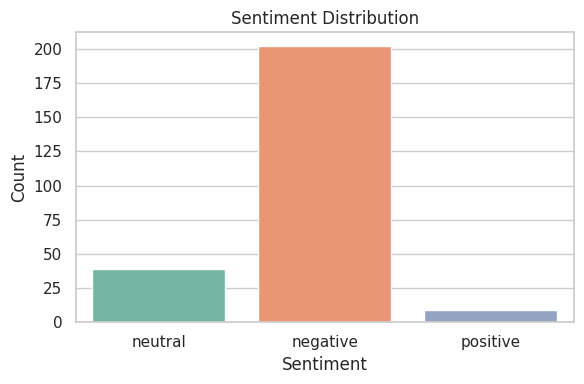

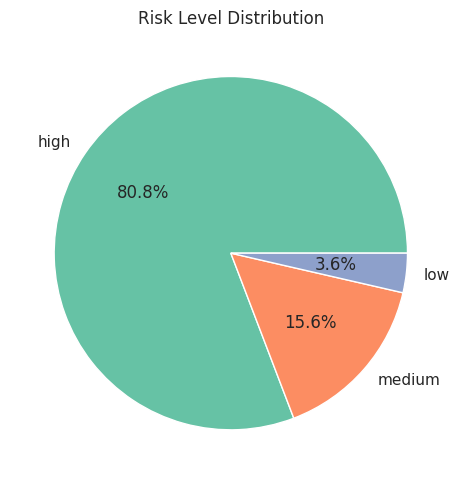

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


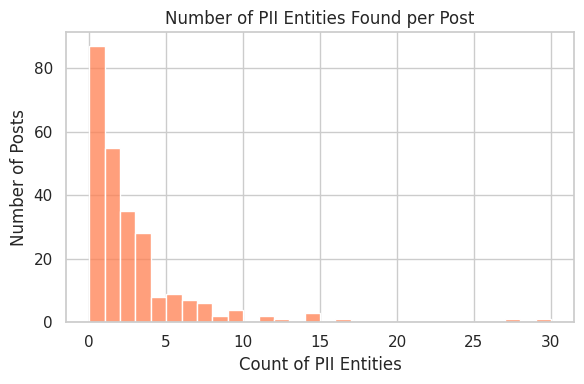

No PII entity types found to plot.


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import ast

# Ensure seaborn uses a pleasant theme
sns.set(style="whitegrid")

# ----------------------------------------
# 📊 1. Sentiment Distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', palette='Set2')
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("sentiment_distribution.png")
plt.show()

# ----------------------------------------
# 🧯 2. Risk Level Distribution (Pie)
plt.figure(figsize=(5,5))
risk_counts = df['risk_level'].value_counts()
plt.pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%', colors=sns.color_palette("Set2"))
plt.title("Risk Level Distribution")
plt.tight_layout()
plt.savefig("risk_pie_chart.png")
plt.show()

# ----------------------------------------
# 🔍 3. Count of Presidio PII Entities per Post
df['pii_entity_count'] = df['presidio_entities'].apply(lambda x: len(x))
plt.figure(figsize=(6,4))
sns.histplot(df['pii_entity_count'], bins=range(0, df['pii_entity_count'].max()+2), kde=False, color='coral')
plt.title("Number of PII Entities Found per Post")
plt.xlabel("Count of PII Entities")
plt.ylabel("Number of Posts")
plt.tight_layout()
plt.savefig("pii_count_histogram.png")
plt.show()

# ----------------------------------------
# 🏷️ 4. Top PII Entity Types
# Flatten and count types
entity_types = []
for entities in df['presidio_entities']:
    try:
        parsed = ast.literal_eval(str(entities))
        entity_types.extend([e.entity_type for e in parsed])
    except:
        continue

entity_type_counts = Counter(entity_types)
if entity_type_counts:
    plt.figure(figsize=(6,4))
    sns.barplot(x=list(entity_type_counts.values()), y=list(entity_type_counts.keys()), palette="magma")
    plt.title("Top PII Entity Types Detected")
    plt.xlabel("Count")
    plt.ylabel("Entity Type")
    plt.tight_layout()
    plt.savefig("pii_entity_types.png")
    plt.show()
else:
    print("No PII entity types found to plot.")
